In [1]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
# Start and end of sentence tokens
SOS_token = 0
EOS_token = 1

In [3]:
class Lang:

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2
    

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def normalizeString(s):

    s = s.lower().strip()
    s = ''.join(
        char for char in unicodedata.normalize('NFD', s)
        if unicodedata.category(char) != 'Mn')
    
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)

    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):

    print('Reading lines...')

    lines = open(f'data/data/{lang1}-{lang2}.txt', encoding='utf-8').\
        read().strip().split('\n')
    
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

Translations between pairs of languages available here: https://www.manythings.org/anki/

In [6]:
MAX_LENGTH = 10

In [7]:
eng_prefixes = ('i am ', 'i m ',
                'he is', 'he s ',
                'she is', 'she s ',
                'you are', 'you re ',
                'we are', 'we re ',
                'they are', 'they re ') # Only sentences starting with these words are being considered


In [11]:
def filterPairs(pairs):
    return [
        pair for pair in pairs
        if
        len(pair[0].split(' ')) < MAX_LENGTH and
        len(pair[1].split(' ')) < MAX_LENGTH and
        pair[1].startswith(eng_prefixes)
    ]

In [12]:
def prepareData(lang1, lang2, reverse=False):

    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(f'Read {len(pairs)} sentence pairs')

    pairs = filterPairs(pairs)
    print(f'Trimmed to {len(pairs)} sentence pairs')

    print('Indexing words...')
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print(f'Counted words:')
    print(f'{input_lang.name}: {input_lang.n_words}')
    print(f'{output_lang.name}: {output_lang.n_words}')

    return input_lang, output_lang, pairs

In [13]:
# German to English
input_lang, output_lang, pairs = prepareData('eng', 'deu', reverse=True)
print(random.choice(pairs))

Reading lines...
Read 176692 sentence pairs
Trimmed to 9678 sentence pairs
Indexing words...
Counted words:
deu: 4494
eng: 2913
['sie hoffen auf sie um hilfe zu erhalten .', 'they are looking to you for help .']


In [14]:
class EncoderRNN(nn.Module):


    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    

    def forward(self, input, hidden):

        embedded = self.embedding(input).view(1, 1, -1) # [1, hidden_size] -> [1, 1, hidden_size]
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [15]:
class DecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [16]:
def tensorFromSentence(lang, sentence):
    indices = [lang.word2index[word] for word in sentence.split(' ')]
    indices.append(EOS_token)
    return torch.tensor(indices, dtype=torch.long).view(-1, 1) # [sentence_length, 1]

In [17]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
teacher_forcing_ratio = 0.5 # Hyperparameter
# Teacher Forcing is when the model is forced to use the token from target as the next input

In [19]:
def train(input_tensor, target_tensor,
            encoder, decoder,
            encoder_optimizer, decoder_optimizer,
            criterion):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    
    decoder_input = torch.tensor([[SOS_token]]) # Start of sentence token as first input to the decoder

    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # Teacher forcing
    
    else:

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break # Stop at end of sentence (output EOS token)
            
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length       

In [21]:
plot_losses = []
print_loss_total = 0
plot_loss_total = 0

In [22]:
hidden_size = 256

In [23]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)

In [24]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.01)

training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(30000)]
criterion = nn.NLLLoss()

iteration: 01000 loss: 3.6345
iteration: 02000 loss: 3.2651
iteration: 03000 loss: 3.0473
iteration: 04000 loss: 2.9312
iteration: 05000 loss: 2.8167
iteration: 06000 loss: 2.7443
iteration: 07000 loss: 2.6923
iteration: 08000 loss: 2.6087
iteration: 09000 loss: 2.5123
iteration: 10000 loss: 2.4533
iteration: 11000 loss: 2.3452
iteration: 12000 loss: 2.3263
iteration: 13000 loss: 2.2818
iteration: 14000 loss: 2.1894
iteration: 15000 loss: 2.1427
iteration: 16000 loss: 2.1147
iteration: 17000 loss: 1.9943
iteration: 18000 loss: 1.9797
iteration: 19000 loss: 1.9287
iteration: 20000 loss: 1.8702
iteration: 21000 loss: 1.8245
iteration: 22000 loss: 1.7814
iteration: 23000 loss: 1.7377
iteration: 24000 loss: 1.6899
iteration: 25000 loss: 1.7536
iteration: 26000 loss: 1.5937
iteration: 27000 loss: 1.5639
iteration: 28000 loss: 1.5629
iteration: 29000 loss: 1.4744
iteration: 30000 loss: 1.5608


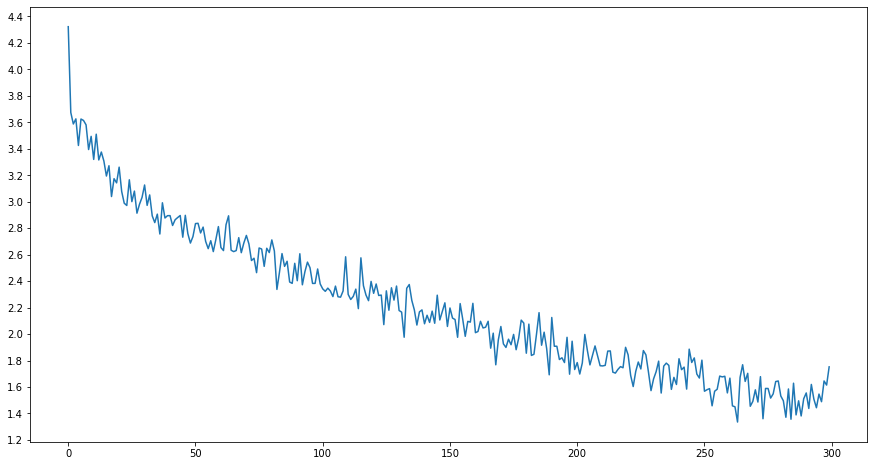

In [27]:
for iter in range(1, 30001):

    input_tensor, output_tensor = training_pairs[iter - 1]

    loss = train(input_tensor, output_tensor,
                    encoder1, decoder1,
                    encoder_optimizer, decoder_optimizer,
                    criterion)
    
    print_loss_total += loss
    plot_loss_total += loss

    if iter % 1000 == 0:
        print_loss_avg = print_loss_total / 1000
        print_loss_total = 0
        print(f'iteration: {iter:05} loss: {print_loss_avg:.4f}')
    
    if iter % 100 == 0:
        plot_loss_avg = plot_loss_total / 100
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

fig, ax = plt.subplots(figsize=(15, 8))
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(plot_losses)

In [28]:
def evaluate(encoder, decoder, sentence):

    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]

        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        
        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)

            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = topi.squeeze().detach()
    
    return decoded_words
            

In [29]:
for i in range(10):

    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words = evaluate(encoder1, decoder1, pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')

> ich gehe nachste woche nach europa .
= i m going to europe next week .
< i m going to to to paris . <EOS>

> ich ziehe mich um .
= i am changing my clothes .
< i am very pleased . <EOS>

> ich bin verheiratet und habe zwei kinder .
= i am married and have two children .
< i m married and thirsty . . <EOS>

> er kommt oft zu spat zur schule .
= he is often late for school .
< he is too late to for . . . <EOS>

> ich bin toms tante .
= i m tom s aunt .
< i m tom s . <EOS>

> ich habe viel zu tun .
= i m a busy guy .
< i m busy to do . <EOS>

> ich uberlege mir ein buch zu schreiben .
= i m thinking of writing a book .
< i m writing a of of . . . <EOS>

> er ist ein typischer arbeitshai .
= he s a typical workaholic .
< he s a teacher . <EOS>

> du bist nicht reich .
= you aren t rich .
< you aren t rich . <EOS>

> ich lese gerade ein buch .
= i am reading a book now .
< i m reading a book book . . <EOS>

